# Загрузка данных 

Kaggle link:https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling?resource=download

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

plt.style.use("dark_background")

In [260]:
df = pd.read_csv("/Users/olegyarygin/Projects/Data-Science/Data/churn-modelling/Churn_Modelling.csv")

In [261]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Обучающая, валидационная и тестовая выборка 

In [262]:
from sklearn.model_selection import train_test_split

In [263]:
train, test = train_test_split(df, random_state=42, train_size = 0.6, stratify= df["Exited"]) # random_state чтобы эксперимент навсегда сохранился

In [264]:
train, test = train_test_split(df, random_state=42, train_size = 0.6, stratify= df["Exited"]) # random_state чтобы эксперимент навсегда сохранился

# Человеческое обучение

In [265]:
train["age_group"] = pd.cut(train["Age"], [0, 31, 35, 40, 46, float("inf")])

In [266]:
model = train.groupby(["NumOfProducts", "age_group"])["Exited"].mean().reset_index()

In [267]:
model = model.rename({"Exited":"score_prod_age"}, axis=1)

In [268]:
train = train.merge(model, how="left", on=["NumOfProducts", "age_group"])

In [269]:
test["age_group"] = pd.cut(test["Age"], [0, 31, 35, 40, 46, float("inf")])

In [270]:
test = test.merge(model, how="left", on=["NumOfProducts", "age_group"])

# Машинное обучение 

In [271]:
from catboost import CatBoostClassifier

In [272]:
X = ['CreditScore', 'Age', 'Tenure', 'Balance', 
     'NumOfProducts', "Geography", "Gender", 'HasCrCard','IsActiveMember', 
     'EstimatedSalary']

cat_features = ['Geography','Gender']

y = ['Exited']

In [273]:
from catboost import Pool

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

In [274]:
params = {"verbose": 100, 
          "random_seed": 42,
         "learning_rate": 0.01}

In [275]:
model = CatBoostClassifier(**params)


In [276]:
model.fit(train_data, eval_set=valid_data)

0:	learn: 0.6843626	test: 0.6843626	best: 0.6843626 (0)	total: 4.54ms	remaining: 4.53s
100:	learn: 0.3896495	test: 0.3897331	best: 0.3897331 (100)	total: 386ms	remaining: 3.44s
200:	learn: 0.3460826	test: 0.3460951	best: 0.3460951 (200)	total: 743ms	remaining: 2.95s
300:	learn: 0.3296722	test: 0.3297279	best: 0.3297279 (300)	total: 1.09s	remaining: 2.53s
400:	learn: 0.3207018	test: 0.3208565	best: 0.3208565 (400)	total: 1.43s	remaining: 2.14s
500:	learn: 0.3138765	test: 0.3142470	best: 0.3142470 (500)	total: 1.82s	remaining: 1.81s
600:	learn: 0.3087578	test: 0.3092560	best: 0.3092560 (600)	total: 2.19s	remaining: 1.46s
700:	learn: 0.3033494	test: 0.3040332	best: 0.3040332 (700)	total: 2.54s	remaining: 1.08s
800:	learn: 0.2982604	test: 0.2991963	best: 0.2991963 (800)	total: 2.88s	remaining: 716ms
900:	learn: 0.2934621	test: 0.2945856	best: 0.2945856 (900)	total: 3.23s	remaining: 355ms
999:	learn: 0.2887838	test: 0.2901222	best: 0.2901222 (999)	total: 3.57s	remaining: 0us

bestTest = 0.2

In [277]:
test["score_catboost"] = model.predict_proba(test[X])[:,1]

In [278]:
test["score_catboost"].head()

0    0.061561
1    0.188889
2    0.039944
3    0.197921
4    0.089839
Name: score_catboost, dtype: float64

# Скор и пороги

In [279]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost
0,8771,15656901,Nnonso,615,France,Male,59,8,0.00,2,1,1,165576.55,0,"(46.0, inf]",0.236364,0.061561
1,3910,15726487,P'eng,431,France,Male,63,6,160982.89,1,1,1,168008.17,0,"(46.0, inf]",0.527607,0.188889
2,9123,15748595,Stanton,689,France,Female,29,1,77556.79,2,1,1,122998.26,0,"(0.0, 31.0]",0.033289,0.039944
3,924,15601026,Gallagher,572,Germany,Female,19,1,138657.08,1,1,1,16161.82,0,"(0.0, 31.0]",0.110764,0.197921
4,6125,15643359,Carter,736,Spain,Male,32,7,0.00,1,0,1,79082.62,0,"(31.0, 35.0]",0.140449,0.089839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4621,15798960,Meng,680,France,Male,33,2,108393.35,1,0,1,39057.67,0,"(31.0, 35.0]",0.140449,0.038440
3996,363,15706365,Bianchi,648,France,Female,50,9,102535.57,1,1,1,189543.19,0,"(46.0, inf]",0.527607,0.356512
3997,6558,15707242,Ibeamaka,504,Spain,Male,40,5,0.00,2,0,0,146703.36,0,"(35.0, 40.0]",0.061069,0.048873
3998,5062,15734005,Mazzi,633,France,Female,42,1,0.00,2,1,0,56865.62,0,"(40.0, 46.0]",0.108647,0.071422


In [280]:
# Чем меньше score, тем меньше человек склонен к оттоку 

In [281]:
# Чем больше score, тем больше человек склонен к оттоку 

<Axes: >

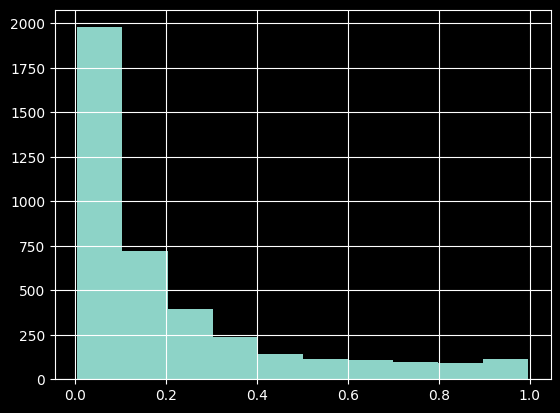

In [282]:
test["score_catboost"].hist()

In [283]:
test["Exited"].mean()

0.20375

In [284]:
test["y_pred"] = (test["score_catboost"] > 0.5) * 1

In [285]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred
0,8771,15656901,Nnonso,615,France,Male,59,8,0.00,2,1,1,165576.55,0,"(46.0, inf]",0.236364,0.061561,0
1,3910,15726487,P'eng,431,France,Male,63,6,160982.89,1,1,1,168008.17,0,"(46.0, inf]",0.527607,0.188889,0
2,9123,15748595,Stanton,689,France,Female,29,1,77556.79,2,1,1,122998.26,0,"(0.0, 31.0]",0.033289,0.039944,0
3,924,15601026,Gallagher,572,Germany,Female,19,1,138657.08,1,1,1,16161.82,0,"(0.0, 31.0]",0.110764,0.197921,0
4,6125,15643359,Carter,736,Spain,Male,32,7,0.00,1,0,1,79082.62,0,"(31.0, 35.0]",0.140449,0.089839,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4621,15798960,Meng,680,France,Male,33,2,108393.35,1,0,1,39057.67,0,"(31.0, 35.0]",0.140449,0.038440,0
3996,363,15706365,Bianchi,648,France,Female,50,9,102535.57,1,1,1,189543.19,0,"(46.0, inf]",0.527607,0.356512,0
3997,6558,15707242,Ibeamaka,504,Spain,Male,40,5,0.00,2,0,0,146703.36,0,"(35.0, 40.0]",0.061069,0.048873,0
3998,5062,15734005,Mazzi,633,France,Female,42,1,0.00,2,1,0,56865.62,0,"(40.0, 46.0]",0.108647,0.071422,0


In [286]:
test["y_pred"].mean()

0.133

# Матрица ошибок 

In [287]:
# Exited - цель 
# y - true | y - pred
# 0          0  - Negative 
# 1          1 - Positive 
#______________
# 0          0 - True Negative  (TN)
# 0          1 - False Positive (FP)
# 1          0 - False Negative (FN)
# 1          1 - True Positive  (TP)

In [288]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred
0,8771,15656901,Nnonso,615,France,Male,59,8,0.00,2,1,1,165576.55,0,"(46.0, inf]",0.236364,0.061561,0
1,3910,15726487,P'eng,431,France,Male,63,6,160982.89,1,1,1,168008.17,0,"(46.0, inf]",0.527607,0.188889,0
2,9123,15748595,Stanton,689,France,Female,29,1,77556.79,2,1,1,122998.26,0,"(0.0, 31.0]",0.033289,0.039944,0
3,924,15601026,Gallagher,572,Germany,Female,19,1,138657.08,1,1,1,16161.82,0,"(0.0, 31.0]",0.110764,0.197921,0
4,6125,15643359,Carter,736,Spain,Male,32,7,0.00,1,0,1,79082.62,0,"(31.0, 35.0]",0.140449,0.089839,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4621,15798960,Meng,680,France,Male,33,2,108393.35,1,0,1,39057.67,0,"(31.0, 35.0]",0.140449,0.038440,0
3996,363,15706365,Bianchi,648,France,Female,50,9,102535.57,1,1,1,189543.19,0,"(46.0, inf]",0.527607,0.356512,0
3997,6558,15707242,Ibeamaka,504,Spain,Male,40,5,0.00,2,0,0,146703.36,0,"(35.0, 40.0]",0.061069,0.048873,0
3998,5062,15734005,Mazzi,633,France,Female,42,1,0.00,2,1,0,56865.62,0,"(40.0, 46.0]",0.108647,0.071422,0


In [289]:
from sklearn.metrics import confusion_matrix

In [290]:
confusion_matrix(test["Exited"], test["y_pred"])

array([[3064,  121],
       [ 404,  411]])

In [291]:
tn,fp,fn,tp = confusion_matrix(test["Exited"], test["y_pred"]).ravel()

In [292]:
tn,fp,fn,tp

(3064, 121, 404, 411)

# https://en.wikipedia.org/wiki/Receiver_operating_characteristic

# Метрики 

# Recall (полнота)

In [293]:
recall = tp / (tp + fn)

In [294]:
recall

0.5042944785276073

In [295]:
from sklearn.metrics import recall_score

In [296]:
recall_score(test["Exited"], test["y_pred"])

0.5042944785276073

In [297]:
# Одного recall не достаточно чтобы оценить качество классификации

In [298]:
test["y_pred_1"] = 1

In [299]:
recall_score(test["Exited"], test["y_pred_1"])

1.0

# Precision (точность)

In [300]:
precision = tp / (tp + fp)

In [301]:
precision

0.7725563909774437

In [302]:
from sklearn.metrics import precision_score

In [303]:
precision_score(test["Exited"], test["y_pred"])

0.7725563909774437

In [304]:
precision_score(test["Exited"], test["y_pred_1"])

0.20375

Пример recall и precision из жизни:

100 картинок только, с кошкой - ребенок определил, что это кошка 80 раз 
recall = 80 / 100 = 0.8 или 80% 

100 картинок не только с кошками, 50 раз сказал мяу, посмотрели на эти 50 и поняли, что только на на 20 есть кошка

precision = 20 / 50 = 0.4 или 40% 

# F1 - общая метрика, объединяющая recall и precision 

In [305]:
f1 = (2 * recall * precision) / (recall + precision)

In [306]:
f1 # частный случай F метрики 

0.6102449888641425

In [307]:
from sklearn.metrics import f1_score


In [308]:
f1_score(test["Exited"], test["y_pred"])

0.6102449888641425

# https://en.wikipedia.org/wiki/F-score

# Accuracy 


In [309]:
# Процент правильных ответов 

In [310]:
(test["Exited"] == test["y_pred"]).mean()

0.86875

In [311]:
(tp + tn) / (tp + tn + fp + fn)

0.86875

In [312]:
from sklearn.metrics import accuracy_score

In [313]:
accuracy_score(test["Exited"], test["y_pred"])

0.86875

In [314]:
test["y_pred_0"] = 0

In [315]:
accuracy_score(test["Exited"], test["y_pred_0"])

0.79625

In [316]:
# Эту метрику нельзя использовать, когда у нас не сбалансированы классы 

# Classification report 

In [317]:
from sklearn.metrics import classification_report

In [318]:
print(classification_report(test["Exited"], test["y_pred"]))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      3185
           1       0.77      0.50      0.61       815

    accuracy                           0.87      4000
   macro avg       0.83      0.73      0.77      4000
weighted avg       0.86      0.87      0.86      4000



In [319]:
precision

0.7725563909774437

In [320]:
recall

0.5042944785276073

In [321]:
f1

0.6102449888641425

# Предикт с другим порогом

In [322]:
test["y_pred_new"] = test["y_pred"] = (test["score_catboost"] > 0.4) * 1

In [323]:
f1_score(test["Exited"], test["y_pred"])

0.6330645161290323

In [324]:
f1_score(test["Exited"], test["y_pred_new"])

0.6330645161290323

In [325]:
# F1 для всех возможных порогов

In [326]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred,y_pred_1,y_pred_0,y_pred_new
0,8771,15656901,Nnonso,615,France,Male,59,8,0.00,2,...,1,165576.55,0,"(46.0, inf]",0.236364,0.061561,0,1,0,0
1,3910,15726487,P'eng,431,France,Male,63,6,160982.89,1,...,1,168008.17,0,"(46.0, inf]",0.527607,0.188889,0,1,0,0
2,9123,15748595,Stanton,689,France,Female,29,1,77556.79,2,...,1,122998.26,0,"(0.0, 31.0]",0.033289,0.039944,0,1,0,0
3,924,15601026,Gallagher,572,Germany,Female,19,1,138657.08,1,...,1,16161.82,0,"(0.0, 31.0]",0.110764,0.197921,0,1,0,0
4,6125,15643359,Carter,736,Spain,Male,32,7,0.00,1,...,1,79082.62,0,"(31.0, 35.0]",0.140449,0.089839,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4621,15798960,Meng,680,France,Male,33,2,108393.35,1,...,1,39057.67,0,"(31.0, 35.0]",0.140449,0.038440,0,1,0,0
3996,363,15706365,Bianchi,648,France,Female,50,9,102535.57,1,...,1,189543.19,0,"(46.0, inf]",0.527607,0.356512,0,1,0,0
3997,6558,15707242,Ibeamaka,504,Spain,Male,40,5,0.00,2,...,0,146703.36,0,"(35.0, 40.0]",0.061069,0.048873,0,1,0,0
3998,5062,15734005,Mazzi,633,France,Female,42,1,0.00,2,...,0,56865.62,0,"(40.0, 46.0]",0.108647,0.071422,0,1,0,0


In [327]:
# 1. catboost 

In [328]:
test["score_catboost"].nunique()

4000

In [329]:
len(test["score_catboost"]))

SyntaxError: unmatched ')' (3443849058.py, line 1)

In [ ]:
thrs = [0] + list(test["score_catboost"].unique()) # thrash holl 

In [ ]:
thrs[:10]

In [ ]:
from tqdm.notebook import tqdm 

In [ ]:
result = []
for thr in thrs:
    test["y_pred_new"] = (test["score_catboost"] > thr) * 1
    result.append((thr, 
                   f1_score(test["Exited"], test["y_pred_new"])))

In [ ]:
result[:20]

In [ ]:
pd.Series(result).sort_values(ascending=False)

In [ ]:
t = pd.DataFrame(result, columns=["thr", "f1"])

In [ ]:
t.sort_values("f1", ascending=False)

In [ ]:
t[t["f1"] == t['f1'].max()]

In [ ]:
# 2. score_prod_age

In [ ]:
thrs = [0] + list(test["score_prod_age"].unique()) # thrash holl 


In [ ]:
result = []
for thr in thrs:
    test["y_pred_new"] = (test["score_prod_age"] > thr) * 1
    result.append((thr, 
                   f1_score(test["Exited"], test["y_pred_new"])))

In [ ]:
pd.Series(result).sort_values(ascending=False)

In [ ]:
t = pd.DataFrame(result, columns=["thr", "f1"])

t.sort_values("f1", ascending=False)

In [ ]:
t[t["f1"] == t['f1'].max()]

In [ ]:
# Ручная модель проигрывает catboost по f1 метрики 

# Roc

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fprs, tprs,thrs = roc_curve(test["Exited"], test["score_catboost"])

In [ ]:
roc = pd.DataFrame({"fprs":fprs, "tprs":tprs, "thrs":thrs})

In [ ]:
roc

In [ ]:
roc.set_index("fprs")["tprs"].plot(figsize=(6,6))

In [ ]:
roc.plot(x="fprs", y="tprs", figsize=(6,6), grid=True)

In [ ]:
roc["random"] = roc["fprs"]

In [ ]:
roc.plot(x="fprs", y=["tprs","random"], figsize=(6,6), grid=True)

In [ ]:
roc["ideal"] = 1

In [ ]:
roc.plot(x="fprs", y=["tprs","random", "ideal"], figsize=(6,6), grid=True)

# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(test[X])
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test["Exited"], test["score_catboost"])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

In [ ]:
from catboost.utils import get_roc_curve

In [ ]:
test_data = Pool(data=test[X],
                 label=test[y],
                 cat_features=cat_features)

In [ ]:
get_roc_curve(model, test_data, plot=True)

# Aug (площадь под кривой) 

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(test["Exited"], test["score_catboost"])

Поменяем в нашей модели, чтобы мы считали не log_los стандартный, а ROC

In [ ]:
params = {"verbose": 100, 
          "random_seed": 42,
         "learning_rate": 0.01, 
         "eval_metric":"AUC"}

In [ ]:
model = CatBoostClassifier(**params)

In [ ]:
model.fit(train_data, eval_set=valid_data)

In [ ]:
# ROC Auc самая популярная метрика для оценки моделей

In [ ]:
# Удобная метрика, чтобы анализировать ROC кривые 

https://ru.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F

# Roc Auc при сильном несбалансированных классах 

In [ ]:
t = pd.DataFrame({"y_true":[0] * 990 + [1] * 10})

In [ ]:
t["y_true"].mean()

In [ ]:
import numpy as np

In [ ]:
np.random.uniform(0, 0.2) # 0 

In [ ]:
np.random.uniform(0.8, 1) # 1 

In [ ]:
np.concatenate([np.random.uniform(0, 0.2, size = 2 ), np.random.uniform(0.8, 1, size = 3)])

In [ ]:
t = pd.DataFrame({"y_true":[0] * 990 + [1] * 10})

In [ ]:
np.random.seed(42)
t["y_score1"] = np.concatenate([np.random.uniform(0, 0.2, size = 970), 
                                np.random.uniform(0.8, 1, size = 20),
                                np.random.uniform(0, 0.2, size = 5), 
                                np.random.uniform(0.8, 1, size = 5)])

In [ ]:
t

In [ ]:
roc_auc_score(t["y_true"], t["y_score1"])

In [ ]:
np.random.seed(42)
t["y_score2"] = np.concatenate([np.random.uniform(0, 0.2, size = 930), 
                                np.random.uniform(0.8, 1, size = 60),
                                np.random.uniform(0, 0.2, size = 5), 
                                np.random.uniform(0.8, 1, size = 5)])

In [ ]:
roc_auc_score(t["y_true"], t["y_score2"])

# Precision recall curve

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# Дисбанс классов не проблема 

In [ ]:
test["Exited"].mean()

In [ ]:
params = {"verbose": 100, 
          "random_seed": 42,
          "auto_class_weights":"Balanced",
          "eval_metric":"AUC", 
         "learning_rate": 0.01}

In [ ]:
model = CatBoostClassifier(**params)

In [ ]:
model.fit(train_data, eval_set=valid_data)

<Axes: >

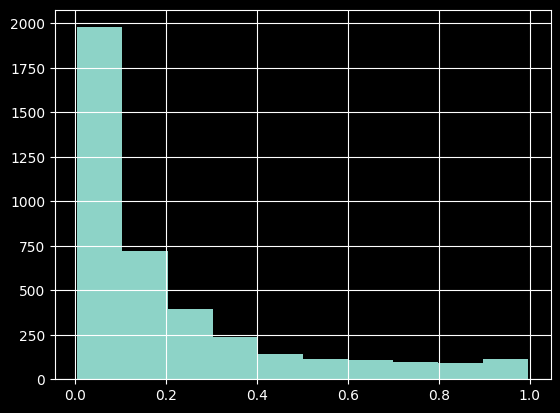

In [330]:
test["score_catboost"].hist()

<Axes: >

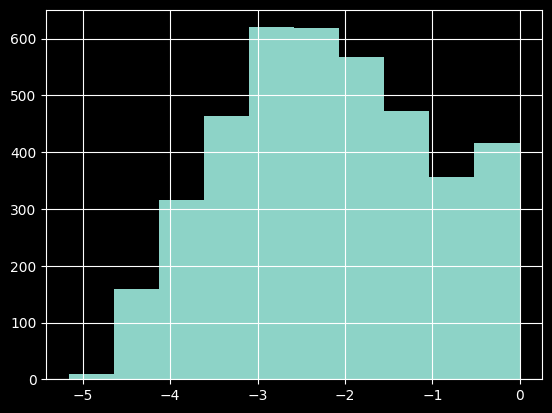

In [331]:
pd.Series(model.predict_log_proba(test[X])[:,1]).hist()

In [332]:
test["score_cat_non_balanced_bins"] = pd.cut(test["score_catboost"], 10)

In [333]:
test.groupby("score_cat_non_balanced_bins")["Exited"].agg(["count", "mean"])

,count,mean
score_cat_non_balanced_bins,,
"(0.00474, 0.105]",1977,0.039960
"(0.105, 0.204]",720,0.127778
"(0.204, 0.303]",395,0.222785
"(0.303, 0.402]",240,0.358333
"(0.402, 0.501]",140,0.428571
"(0.501, 0.6]",115,0.556522
"(0.6, 0.699]",110,0.636364
"(0.699, 0.799]",96,0.854167
"(0.799, 0.898]",94,0.893617


In [334]:
test["score_catboost_balanced"] = model.predict_log_proba(test[X])[:,1]

In [337]:
test["score_cat_balanced_bins"] = pd.cut(test["score_catboost"], 10)

In [339]:
test.groupby("score_cat_balanced_bins")["Exited"].agg(["count", "mean"])

,count,mean
score_cat_balanced_bins,,
"(0.00474, 0.105]",1977,0.039960
"(0.105, 0.204]",720,0.127778
"(0.204, 0.303]",395,0.222785
"(0.303, 0.402]",240,0.358333
"(0.402, 0.501]",140,0.428571
"(0.501, 0.6]",115,0.556522
"(0.6, 0.699]",110,0.636364
"(0.699, 0.799]",96,0.854167
"(0.799, 0.898]",94,0.893617


# Мультикласс

https://scikit-learn.org/stable/modules/multiclass.html

https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification